In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import pandas as pd
import ta
from datetime import datetime, timedelta
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in.*')


def get_stock_data(ticker, years=3):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365*years)

    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def add_technical_indicators(data):
    # Add Stochastic Oscillator (%K)
    stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'])
    data['%K'] = stoch.stoch()

    # Add Relative Strength Index (RSI)
    rsi = ta.momentum.RSIIndicator(data['Close'])
    data['RSI'] = rsi.rsi()

    # Add Simple Moving Average (SMA)
    sma = ta.trend.SMAIndicator(data['Close'], window=20)
    data['SMA'] = sma.sma_indicator()

    # Add Exponential Moving Average (EMA)
    ema = ta.trend.EMAIndicator(data['Close'], window=20)
    data['EMA'] = ema.ema_indicator()

    # Add Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['Close'])
    data['Bollinger_High'] = bollinger.bollinger_hband()
    data['Bollinger_Low'] = bollinger.bollinger_lband()

    # Add Average Directional Index (ADX)
    adx = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'])
    data['ADX'] = adx.adx()

    # Add On Balance Volume (OBV)
    obv = ta.volume.OnBalanceVolumeIndicator(data['Close'], data['Volume'])
    data['OBV'] = obv.on_balance_volume()

    # Add Chaikin Money Flow (CMF)
    cmf = ta.volume.ChaikinMoneyFlowIndicator(data['High'], data['Low'], data['Close'], data['Volume'])
    data['CMF'] = cmf.chaikin_money_flow()

    return data

In [ ]:
ticker = "TSLA"  # Tesla stock symbol
raw_data = get_stock_data(ticker)
processed_data = add_technical_indicators(raw_data)

processed_data.head()


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,%K,RSI,SMA,EMA,Bollinger_High,Bollinger_Low,ADX,OBV,CMF
Date,,,,,,,,,,,,,,,
2020-03-27,33.666668,35.053333,32.935333,34.290668,34.290668,215661000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,215661000,NaN
2020-03-30,34.017334,34.443333,32.748669,33.475334,33.475334,179971500,NaN,NaN,NaN,NaN,NaN,NaN,0.0,35689500,NaN
2020-03-31,33.416668,36.197334,33.133331,34.933334,34.933334,266572500,NaN,NaN,NaN,NaN,NaN,NaN,0.0,302262000,NaN
2020-04-01,33.599998,34.263332,31.673332,32.104000,32.104000,200298000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,101964000,NaN
2020-04-02,32.068668,32.950668,29.760000,30.298000,30.298000,297876000,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-195912000,NaN


In [ ]:
def create_target_and_preprocess(data, shift=1):
    data['Future_Close'] = data['Close'].shift(-shift)
    data['Trend'] = (data['Future_Close'] > data['Close']).astype(int)
    data = data.drop(['Future_Close'], axis=1)
    data = data.dropna()
    return data

def prepare_data_for_feature_selection(data, target_col):
    data = data.copy()
    X = data.drop([target_col], axis=1)
    y = data[target_col]
    return X, y

In [ ]:
ticker = "TSLA"  # Tesla stock symbol
raw_data = get_stock_data(ticker)
processed_data = add_technical_indicators(raw_data)
processed_data = create_target_and_preprocess(processed_data)
processed_data = processed_data.dropna()

[*********************100%***********************]  1 of 1 completed


In [ ]:
processed_data.head()

,Open,High,Low,Close,Adj Close,Volume,%K,RSI,SMA,EMA,Bollinger_High,Bollinger_Low,ADX,OBV,CMF,Trend
Date,,,,,,,,,,,,,,,,
2020-04-24,47.387333,48.715332,46.545334,48.343334,48.343334,198180000,82.021013,67.403192,41.086001,43.062072,55.379258,26.792743,0.0,2373435000,0.016330,1
2020-04-27,49.174000,53.299332,49.000000,53.250000,53.250000,310221000,99.723011,73.938099,42.033967,44.032351,56.902051,27.165883,0.0,2683656000,0.062100,0
2020-04-28,53.042667,53.666668,50.445999,51.274666,51.274666,228330000,86.792790,68.025545,42.923934,44.722095,57.767108,28.080760,0.0,2455326000,0.045515,1
2020-04-29,52.678001,53.546665,52.210667,53.367332,53.367332,243240000,98.188700,70.698777,43.845634,45.545451,58.877755,28.813512,0.0,2698566000,0.070513,0
2020-04-30,57.012669,57.987999,50.900002,52.125332,52.125332,427078500,69.601435,67.112503,44.846700,46.172106,59.272151,30.421250,0.0,2271487500,0.041225,0


In [ ]:
X, y = prepare_data_for_feature_selection(processed_data, 'Trend')

In [ ]:
k = 5  # Change this value to select a different number of top features
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X, y)

cols = selector.get_support(indices=True)
selected_features = X.iloc[:, cols]
print("Top", k, "features:")
print(selected_features.columns)

Top 5 features:
Index(['SMA', 'EMA', 'Bollinger_High', 'Bollinger_Low', 'CMF'], dtype='object')


In [ ]:
# Create a new DataFrame with the selected features, target column, and 'Close' column
final_data = pd.concat([selected_features, processed_data[['Close', 'Trend']]], axis=1)

print("\nFinal data:")
print(final_data.head())


Final data:
                  SMA        EMA  Bollinger_High  Bollinger_Low       CMF  \
Date                                                                        
2020-04-24  41.086001  43.062072       55.379258      26.792743  0.016330   
2020-04-27  42.033967  44.032351       56.902051      27.165883  0.062100   
2020-04-28  42.923934  44.722095       57.767108      28.080760  0.045515   
2020-04-29  43.845634  45.545451       58.877755      28.813512  0.070513   
2020-04-30  44.846700  46.172106       59.272151      30.421250  0.041225   

                Close  Trend  
Date                          
2020-04-24  48.343334      1  
2020-04-27  53.250000      0  
2020-04-28  51.274666      1  
2020-04-29  53.367332      0  
2020-04-30  52.125332      0  


In [ ]:
processed_data.head(100)

,Open,High,Low,Close,Adj Close,Volume,%K,RSI,SMA,EMA,Bollinger_High,Bollinger_Low,ADX,OBV,CMF,Trend
Date,,,,,,,,,,,,,,,,
2020-04-24,47.387333,48.715332,46.545334,48.343334,48.343334,198180000,82.021013,67.403192,41.086001,43.062072,55.379258,26.792743,0.000000,2373435000,0.016330,1
2020-04-27,49.174000,53.299332,49.000000,53.250000,53.250000,310221000,99.723011,73.938099,42.033967,44.032351,56.902051,27.165883,0.000000,2683656000,0.062100,0
2020-04-28,53.042667,53.666668,50.445999,51.274666,51.274666,228330000,86.792790,68.025545,42.923934,44.722095,57.767108,28.080760,0.000000,2455326000,0.045515,1
2020-04-29,52.678001,53.546665,52.210667,53.367332,53.367332,243240000,98.188700,70.698777,43.845634,45.545451,58.877755,28.813512,0.000000,2698566000,0.070513,0
2020-04-30,57.012669,57.987999,50.900002,52.125332,52.125332,427078500,69.601435,67.112503,44.846700,46.172106,59.272151,30.421250,0.000000,2271487500,0.041225,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-09,118.866669,123.000000,113.836670,122.093330,122.093330,238397400,21.087995,48.200243,132.783834,130.157518,166.046172,99.521496,39.086220,5078734800,0.176428,1
2020-09-10,128.736664,132.996674,120.186668,123.779999,123.779999,254791800,24.019462,49.037247,133.790300,129.550135,164.592845,102.987756,36.495480,5333526600,0.123258,1
2020-09-11,127.313332,127.500000,120.166664,124.239998,124.239998,182152500,24.818951,49.277964,134.598967,129.044408,163.444791,105.753143,34.087967,5515679100,0.113930,1


In [ ]:
processed_data.to_csv("tesla_processed_data.csv", index=False)

In [ ]:
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [ ]:
X = final_data.drop('Trend', axis=1)
y = final_data['Trend']

In [ ]:
# # Prepare the dataset
# X = processed_data.drop('Trend', axis=1)
# y = processed_data['Trend']

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)


In [ ]:
# Train the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Make predictions
y_pred = clf.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5102040816326531
Accuracy: 51.02%
Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.52      0.47        61
           1       0.60      0.50      0.54        86

    accuracy                           0.51       147
   macro avg       0.51      0.51      0.51       147
weighted avg       0.53      0.51      0.51       147



In [ ]:
from sklearn.linear_model import LogisticRegression

# Train the Logistic Regression classifier
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 57.82%


In [ ]:
print("Target variable distribution:")
print(y.value_counts(normalize=True) * 100)

Target variable distribution:
1    53.605442
0    46.394558
Name: Trend, dtype: float64


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression

tscv = TimeSeriesSplit(n_splits=5)

X1 = X.values
y1 = y.values

for train_index, test_index in tscv.split(X1):
    X_train1, X_test1 = X1[train_index], X1[test_index]
    y_train1, y_test1 = y1[train_index], y1[test_index]
    
    # Train the Logistic Regression classifier
    clf = LogisticRegression(random_state=42)
    clf.fit(X_train1, y_train1)

    # Make predictions
    y_pred = clf.predict(X_test1)

    # Evaluate the model
    accuracy = accuracy_score(y_test1, y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 46.72%
Accuracy: 56.56%
Accuracy: 53.28%
Accuracy: 59.84%
Accuracy: 46.72%


In [ ]:
# Predict tomorrow's trend
tomorrow_data = X1[-1]
tomorrow_pred = clf.predict([tomorrow_data])

# Print tomorrow's estimated trend along with the data row
print("\nTomorrow's Data:")
print(tomorrow_data)
print("\nTomorrow's Estimated Trend:", 'Uptrend' if tomorrow_pred[0] == 1 else 'Downtrend')


Tomorrow's Data:
[1.88587000e+02 1.87857383e+02 2.08640875e+02 1.68533125e+02
 1.69105047e-02 1.90410004e+02]

Tomorrow's Estimated Trend: Uptrend


## LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [ ]:
# Normalize the data using MinMaxScaler
Scaler = MinMaxScaler(feature_range=(0, 1))
final_lstm_data = Scaler.fit_transform(final_data)

In [ ]:
def Create_Features_and_Targets(data, feature_length):
    X = list()
    Y = list()
    for i in range(len(data) - feature_length - 1):
        X.append(data[i:(i + feature_length), :])
        Y.append(data[i + feature_length, 0])  # Using the 'StockPrice' column as the target
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

In [ ]:
feature_length = 100

In [ ]:
X_train, y_train = Create_Features_and_Targets(final_lstm_data, feature_length)

In [ ]:
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(1),
])

In [ ]:
model.compile(optimizer='adam', loss="mean_squared_error")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100, 100)          43200     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 123,701
Trainable params: 123,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=12,
    verbose=1,
)

Epoch 1/100
53/53 [==============================] - 14s 163ms/step - loss: 0.0292
Epoch 2/100
53/53 [==============================] - 8s 159ms/step - loss: 0.0052
Epoch 3/100
53/53 [==============================] - 9s 176ms/step - loss: 0.0036
Epoch 4/100
53/53 [==============================] - 8s 144ms/step - loss: 0.0039
Epoch 5/100
53/53 [==============================] - 8s 159ms/step - loss: 0.0035
Epoch 6/100
53/53 [==============================] - 8s 150ms/step - loss: 0.0029
Epoch 7/100
53/53 [==============================] - 9s 168ms/step - loss: 0.0029
Epoch 8/100
53/53 [==============================] - 8s 143ms/step - loss: 0.0035
Epoch 9/100
53/53 [==============================] - 9s 161ms/step - loss: 0.0030
Epoch 10/100
53/53 [==============================] - 9s 179ms/step - loss: 0.0030
Epoch 11/100
53/53 [==============================] - 8s 150ms/step - loss: 0.0029
Epoch 12/100
53/53 [==============================] - 9s 171ms/step - loss: 0.0033
Epoch 13/100

In [ ]:
final_data

,SMA,EMA,Bollinger_High,Bollinger_Low,CMF,Close,Trend
Date,,,,,,,
2020-04-24,41.086001,43.062072,55.379258,26.792743,0.016330,48.343334,1
2020-04-27,42.033967,44.032351,56.902051,27.165883,0.062100,53.250000,0
2020-04-28,42.923934,44.722095,57.767108,28.080760,0.045515,51.274666,1
2020-04-29,43.845634,45.545451,58.877755,28.813512,0.070513,53.367332,0
2020-04-30,44.846700,46.172106,59.272151,30.421250,0.041225,52.125332,0
...,...,...,...,...,...,...,...
2023-03-20,189.878001,185.527092,211.565895,168.190107,0.060364,183.250000,1
2023-03-21,189.888501,186.674988,211.591092,168.185910,0.163849,197.580002,0
2023-03-22,189.403001,187.101179,210.528889,168.277113,0.069182,191.149994,1


In [ ]:
# Prepare the test data
testData = final_data[['SMA', 'EMA', 'Bollinger_High', 'Bollinger_Low','CMF', 'Close', 'Trend']].values#, 'DollarPrice', 'DollarChangeRate', 'OilPrice', 'OilChangeRate', 'Interest','InterestRateChange']].values
y_real = testData[feature_length + 1:, 0]  # Actual Values
x_test = Scaler.transform(testData)
x_test, y_test = Create_Features_and_Targets(x_test, feature_length)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Make data 3-dimensional
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))


In [ ]:
# Predict the closing prices
y_pred = model.predict(x_test)
predicted_price = np.hstack((x_test[:, -1, 1:], y_pred))
predicted_price = Scaler.inverse_transform(predicted_price)[:, 0]

20/20 [==============================] - 2s 60ms/step


In [ ]:
# Inverse transform the actual y_test values
actual_prices = Scaler.inverse_transform(np.hstack((x_test[:, -1, 1:], y_test.reshape(-1, 1))))[:, 0]


In [ ]:
tomorrows_estimated_price = predicted_price[-1]
print(f"Tomorrow's estimated stock price: {tomorrows_estimated_price:.2f}")

Tomorrow's estimated stock price: 190.42


In [ ]:
# Calculate the difference between the last predicted price and the current actual price
price_difference = actual_prices[-1] - predicted_price[-1]

# Print the trend based on the price difference
if price_difference > 0:
    trend = 'upwards'
elif price_difference < 0:
    trend = 'downwards'
else:
    trend = 'unchanged'

tomorrows_estimated_price = predicted_price[-1]
print(f"Tomorrow's estimated stock price: {tomorrows_estimated_price:.2f}, Trend: {trend}")

20/20 [==============================] - 2s 109ms/step


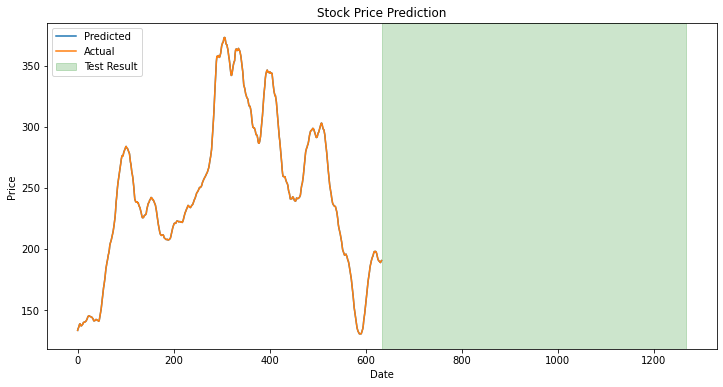

In [ ]:
# Predict the closing prices for the test data
y_pred = model.predict(x_test)
predicted_price = Scaler.inverse_transform(np.hstack((x_test[:, -1, 1:], y_pred)))[:, 0]

# Plot the predicted and actual stock prices along with the test results
plt.figure(figsize=(12, 6))
plt.plot(predicted_price, label='Predicted')
plt.plot(actual_prices, label='Actual')
plt.axvspan(len(actual_prices), len(actual_prices) + len(predicted_price), alpha=0.2, color='green', label='Test Result')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
plt.show()

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Set the seed for reproducibility
np.random.seed(42)

# Load the data
#final_data = np.load('final_data.npy', allow_pickle=True)

# Define the feature length
feature_length = 100

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
final_lstm_data = scaler.fit_transform(final_data)

# Create the training and testing data
def create_features_and_targets(data, feature_length):
    X = []
    Y = []
    for i in range(len(data) - feature_length - 1):
        X.append(data[i:(i + feature_length), :])
        Y.append(data[i + feature_length, 0])  # Using the 'Close' column as the target
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

X_train, y_train = create_features_and_targets(final_lstm_data, feature_length)

# Define the LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=12, verbose=1)



In [ ]:
# Prepare the test data
test_data = final_data[-(feature_length+1):, :].values.reshape((1, feature_length+1, final_data.shape[1]))
x_test = scaler.transform(test_data[:, :-1, :])
y_test = test_data[:, -1, 0]

actual_price = final_data.iloc[-1, 0]

# Make predictions
y_pred = model.predict(x_test)
predicted_price = scaler.inverse_transform(np.hstack((x_test[:, -1, 1:], y_pred)))[:, 0]
actual_price = final_data.iloc[-1, 0]

# Calculate the trend
price_difference = actual_price - predicted_price[-1]
if price_difference > 0:
    trend = 'down'
elif price_difference < 0:
    trend = 'up'
else:
    trend = 'unchanged'

# Print the results
print(f"Tomorrow's estimated close price: {predicted_price[-1]:.2f}")
print(f"Tomorrow's estimated trend: {trend}")

In [ ]:
X_train.shape

(634, 100, 7)